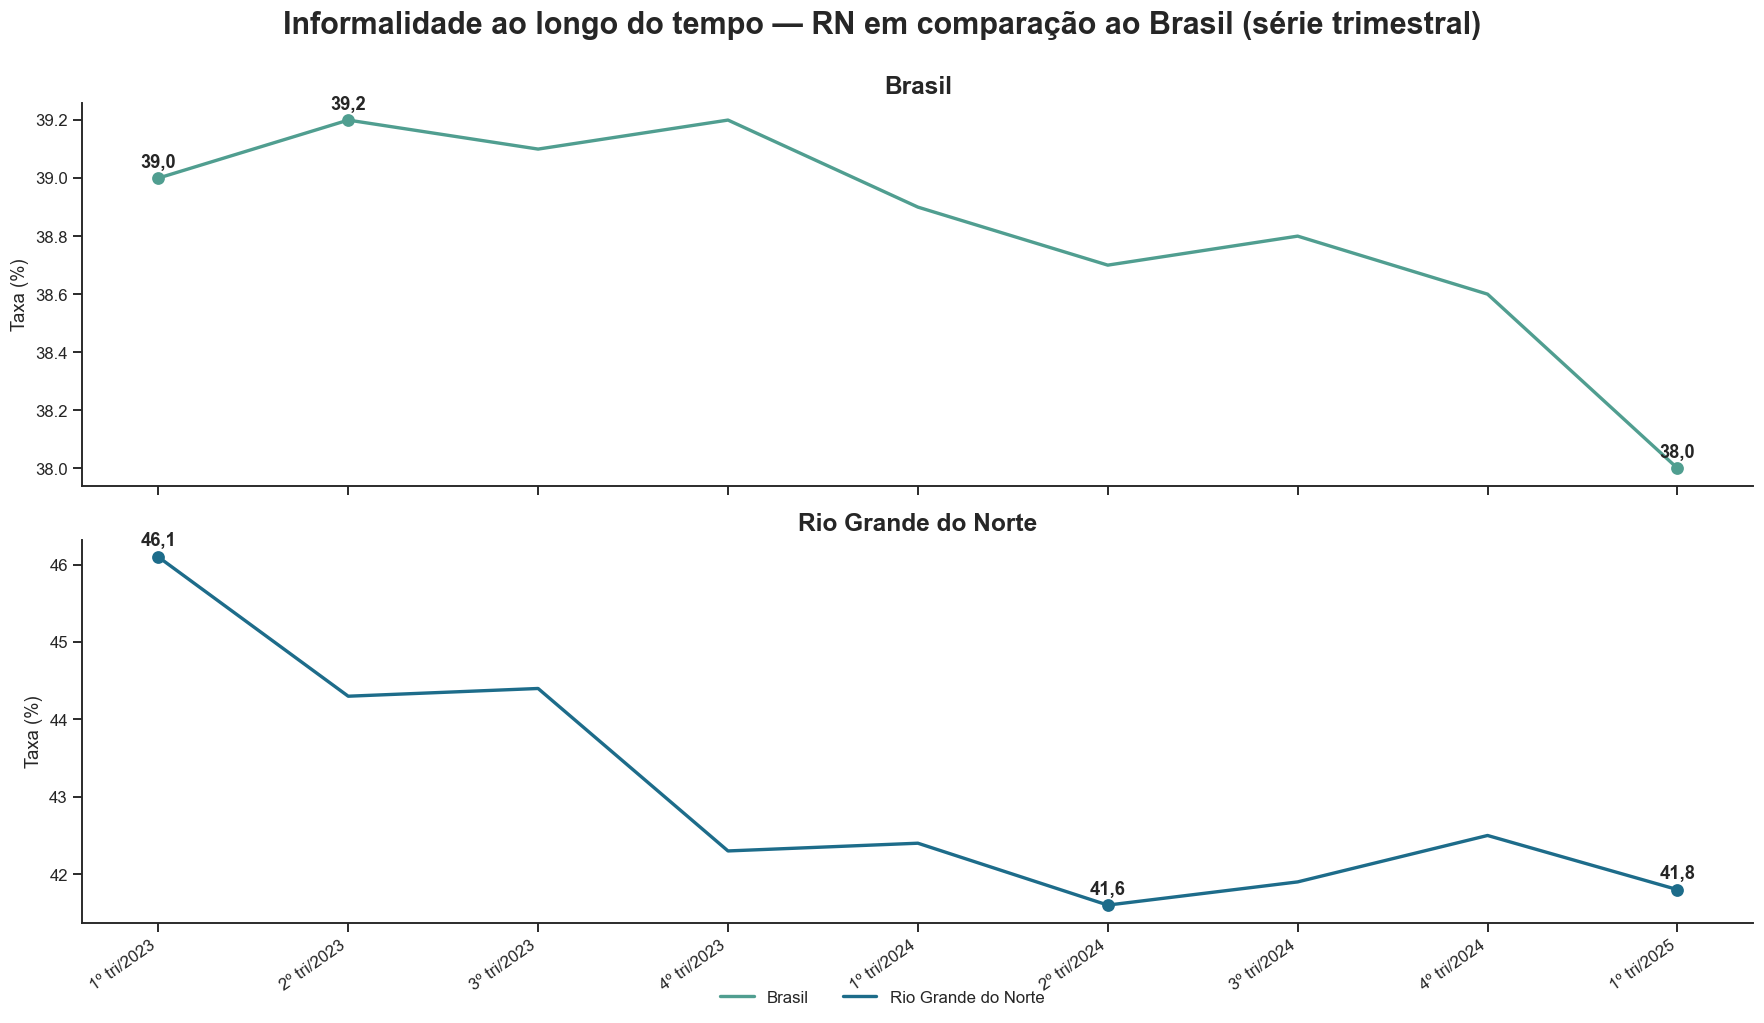

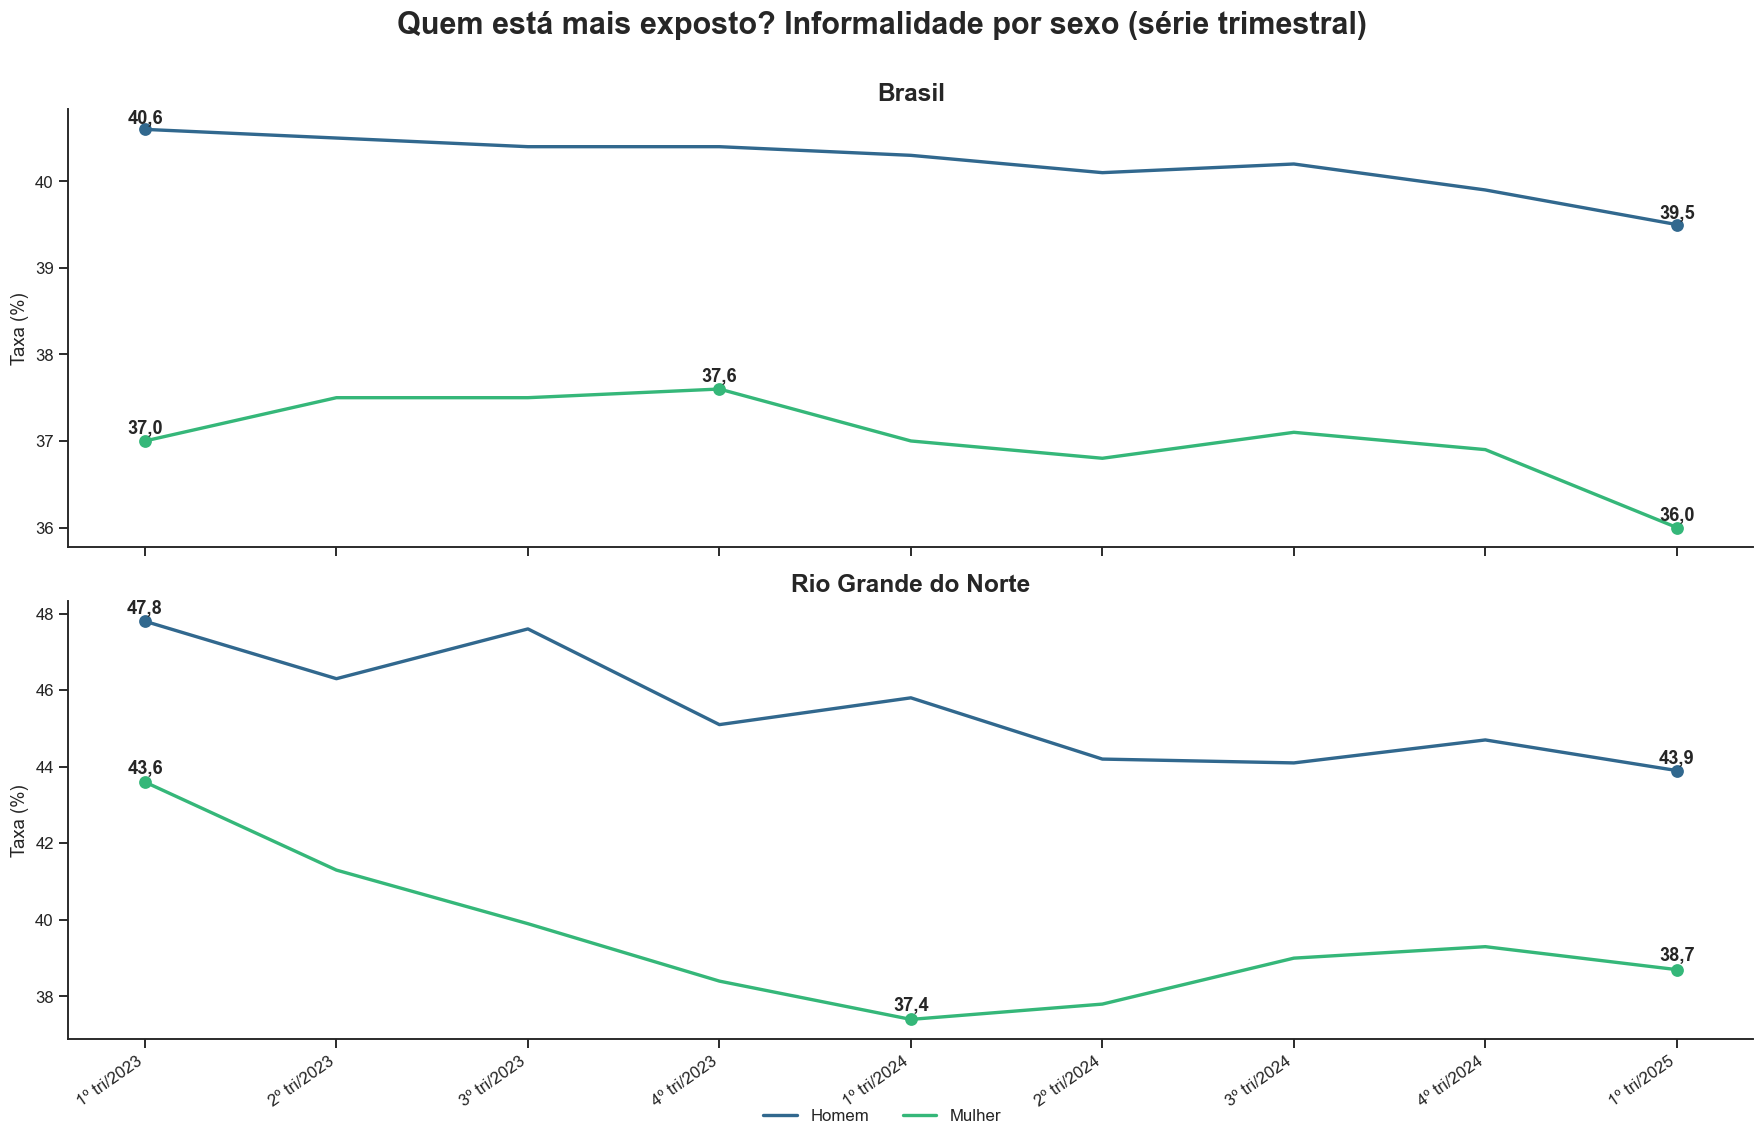

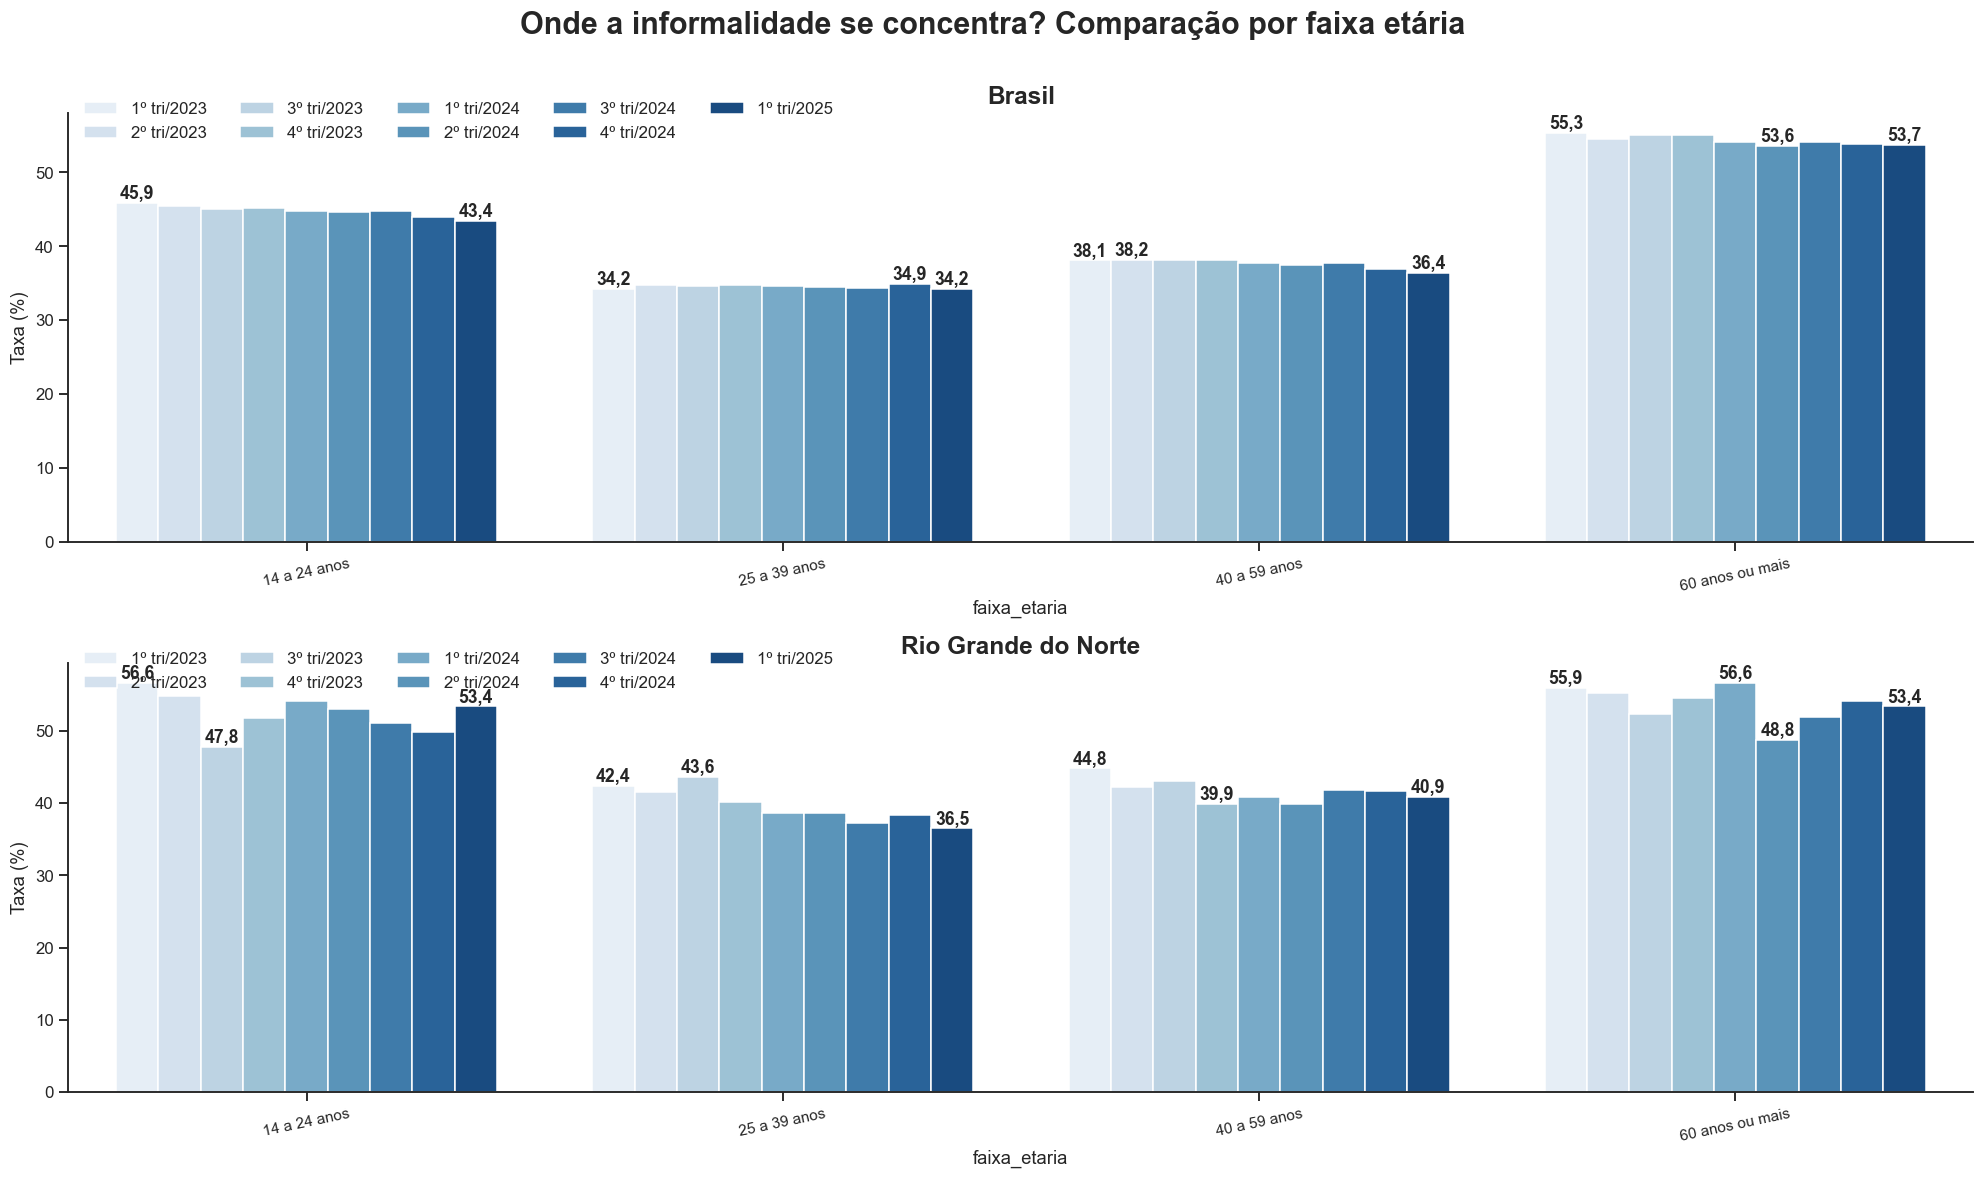

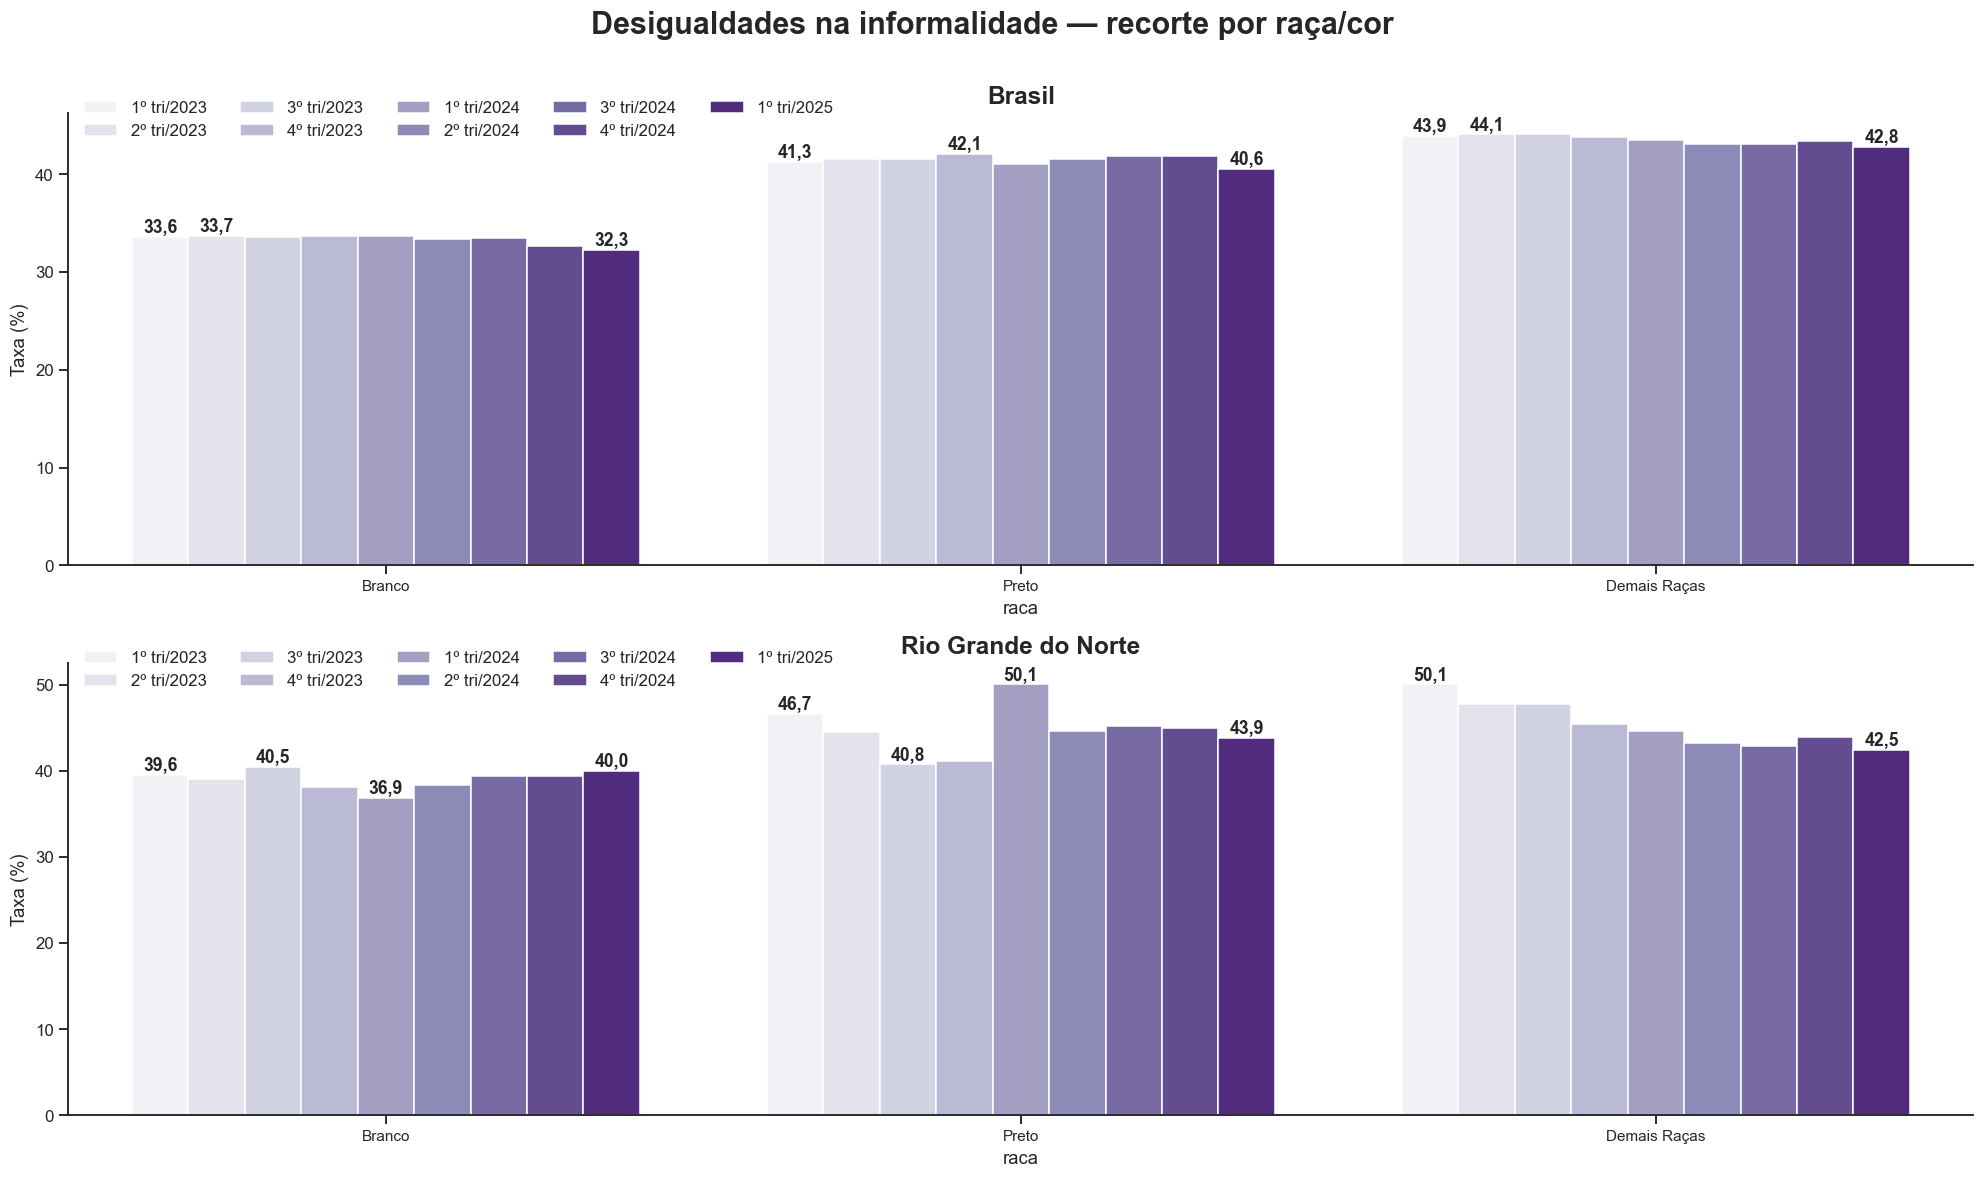

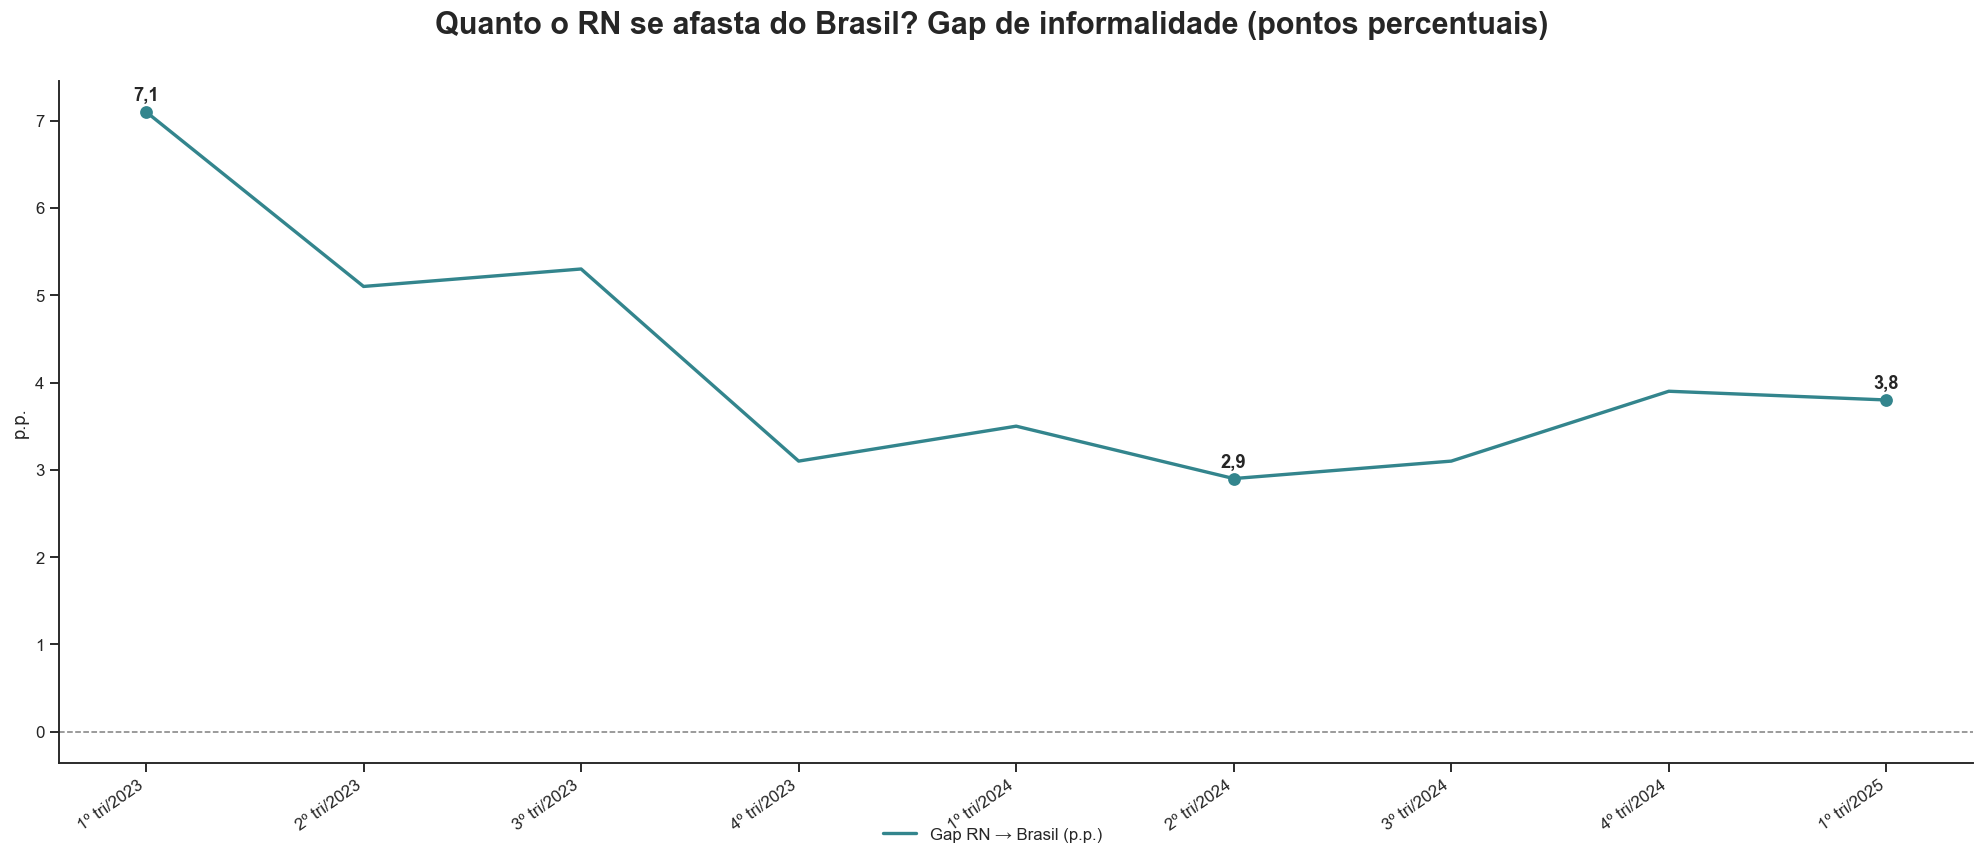

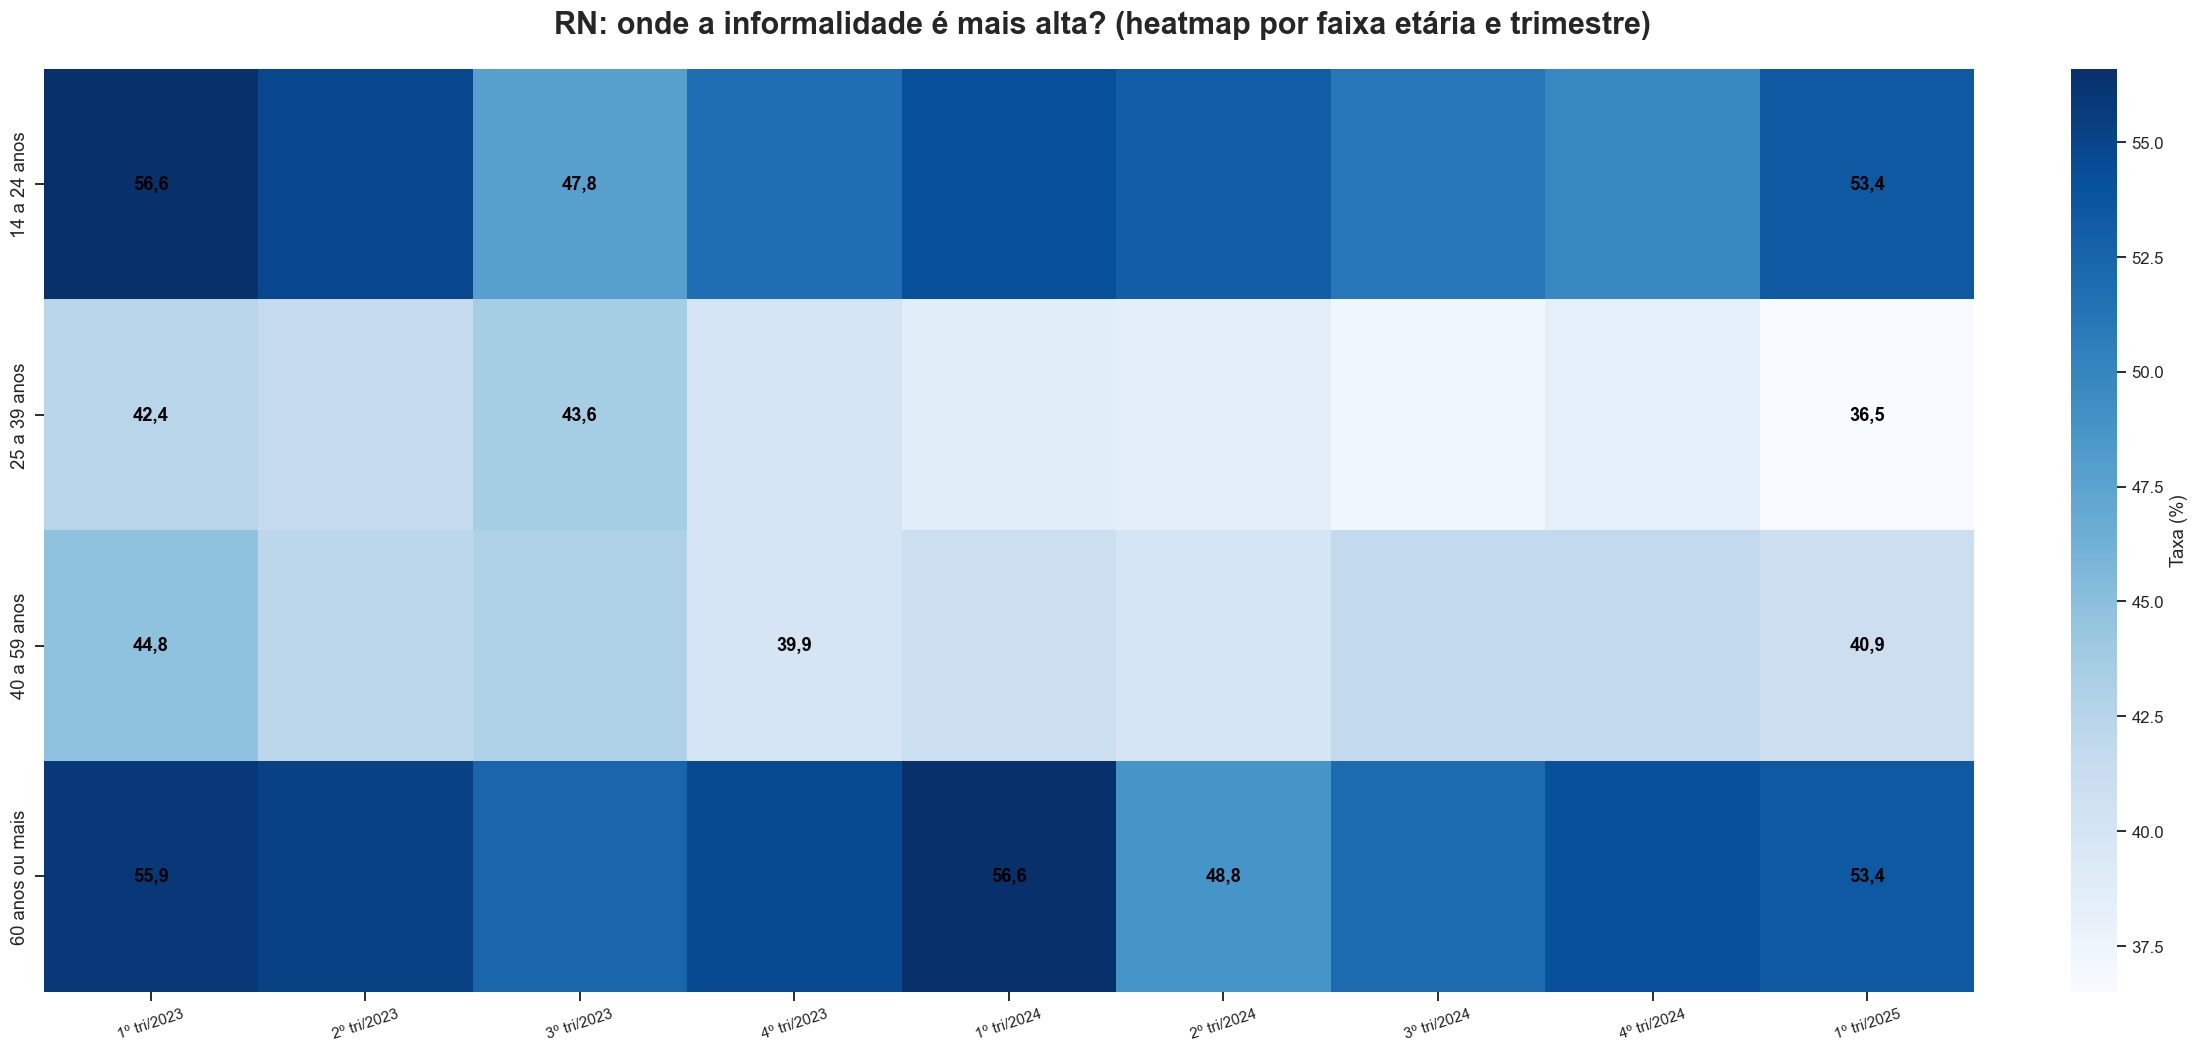

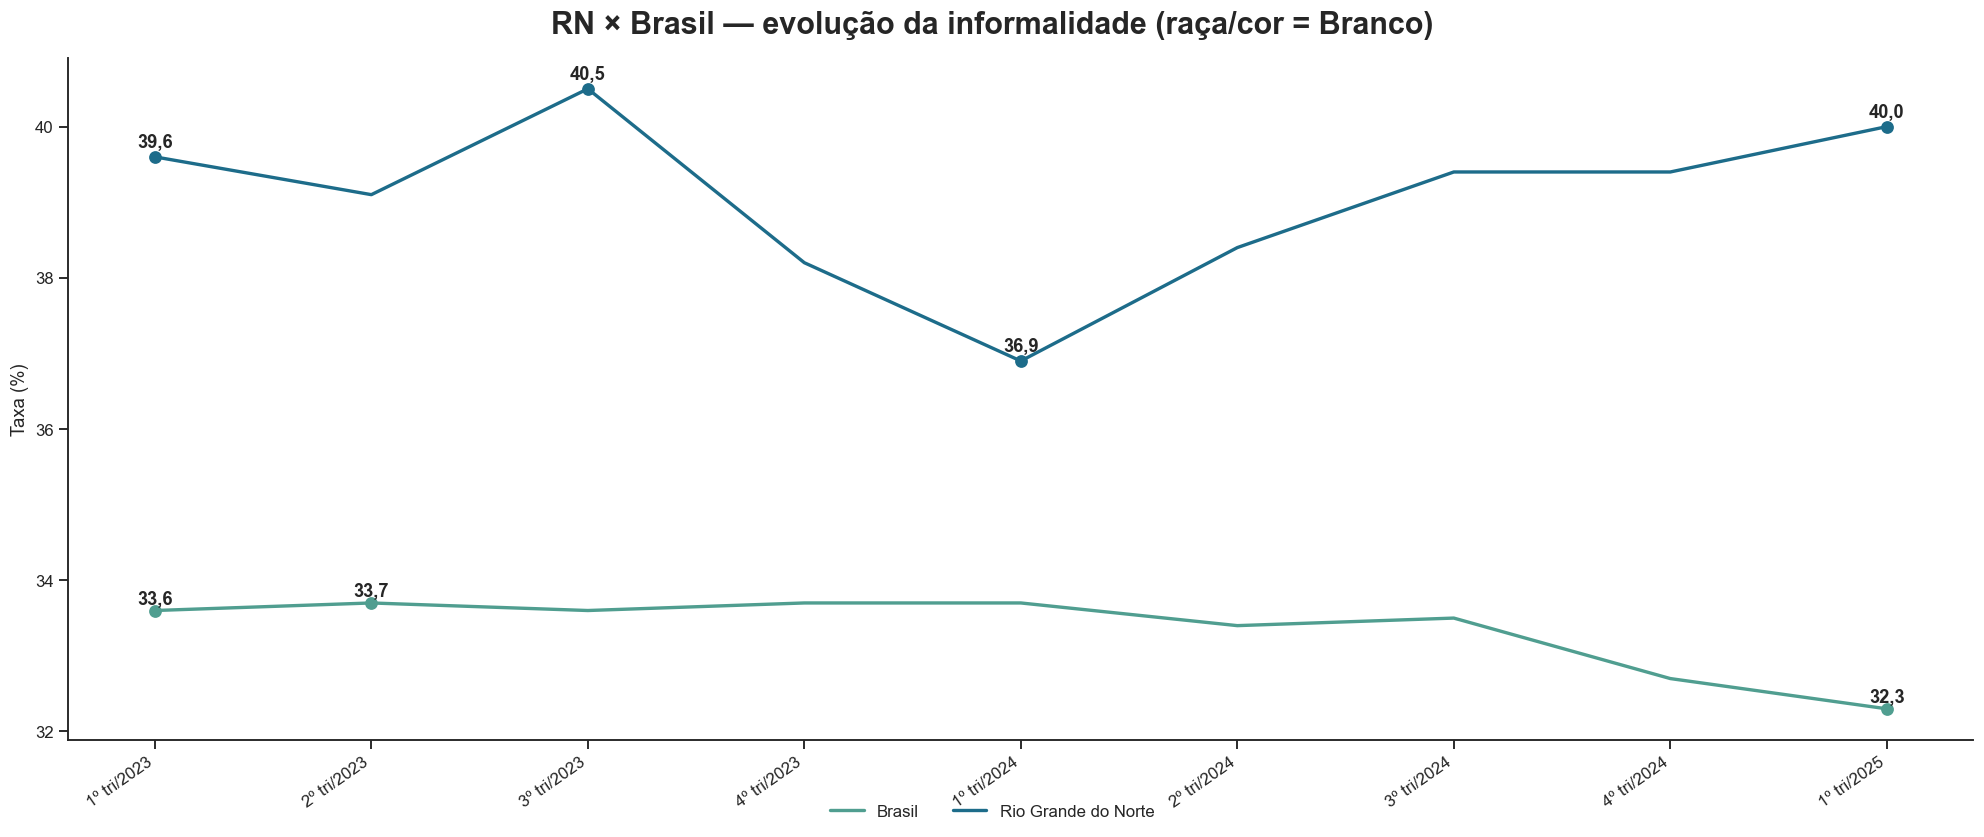

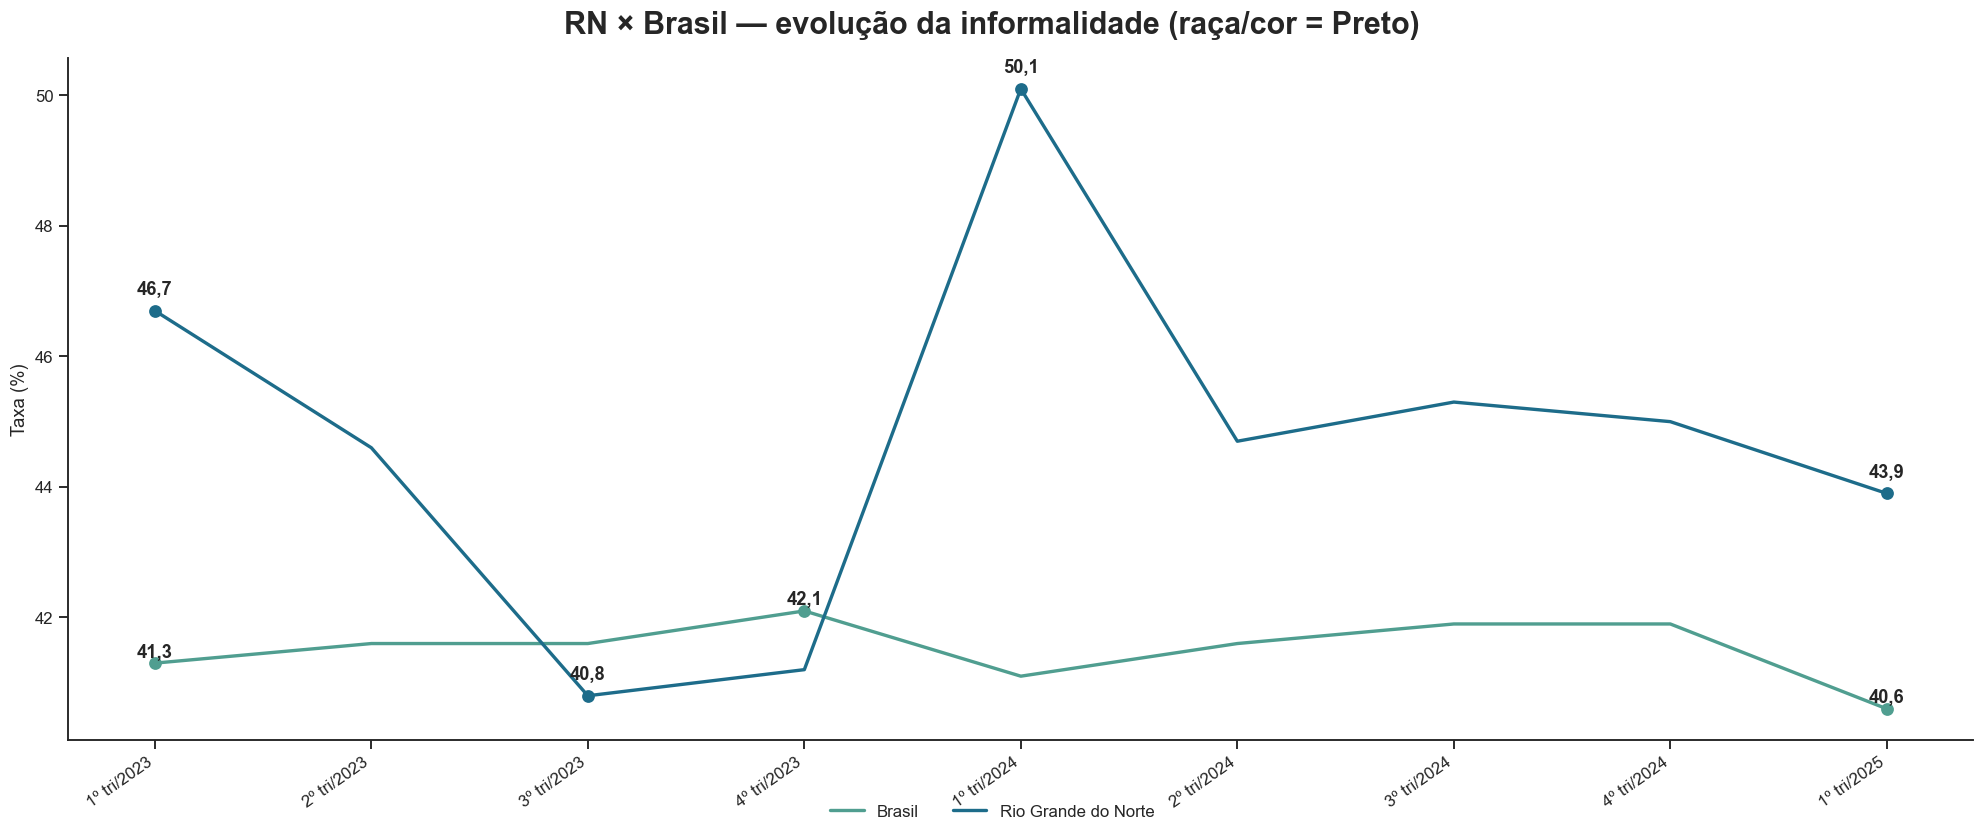

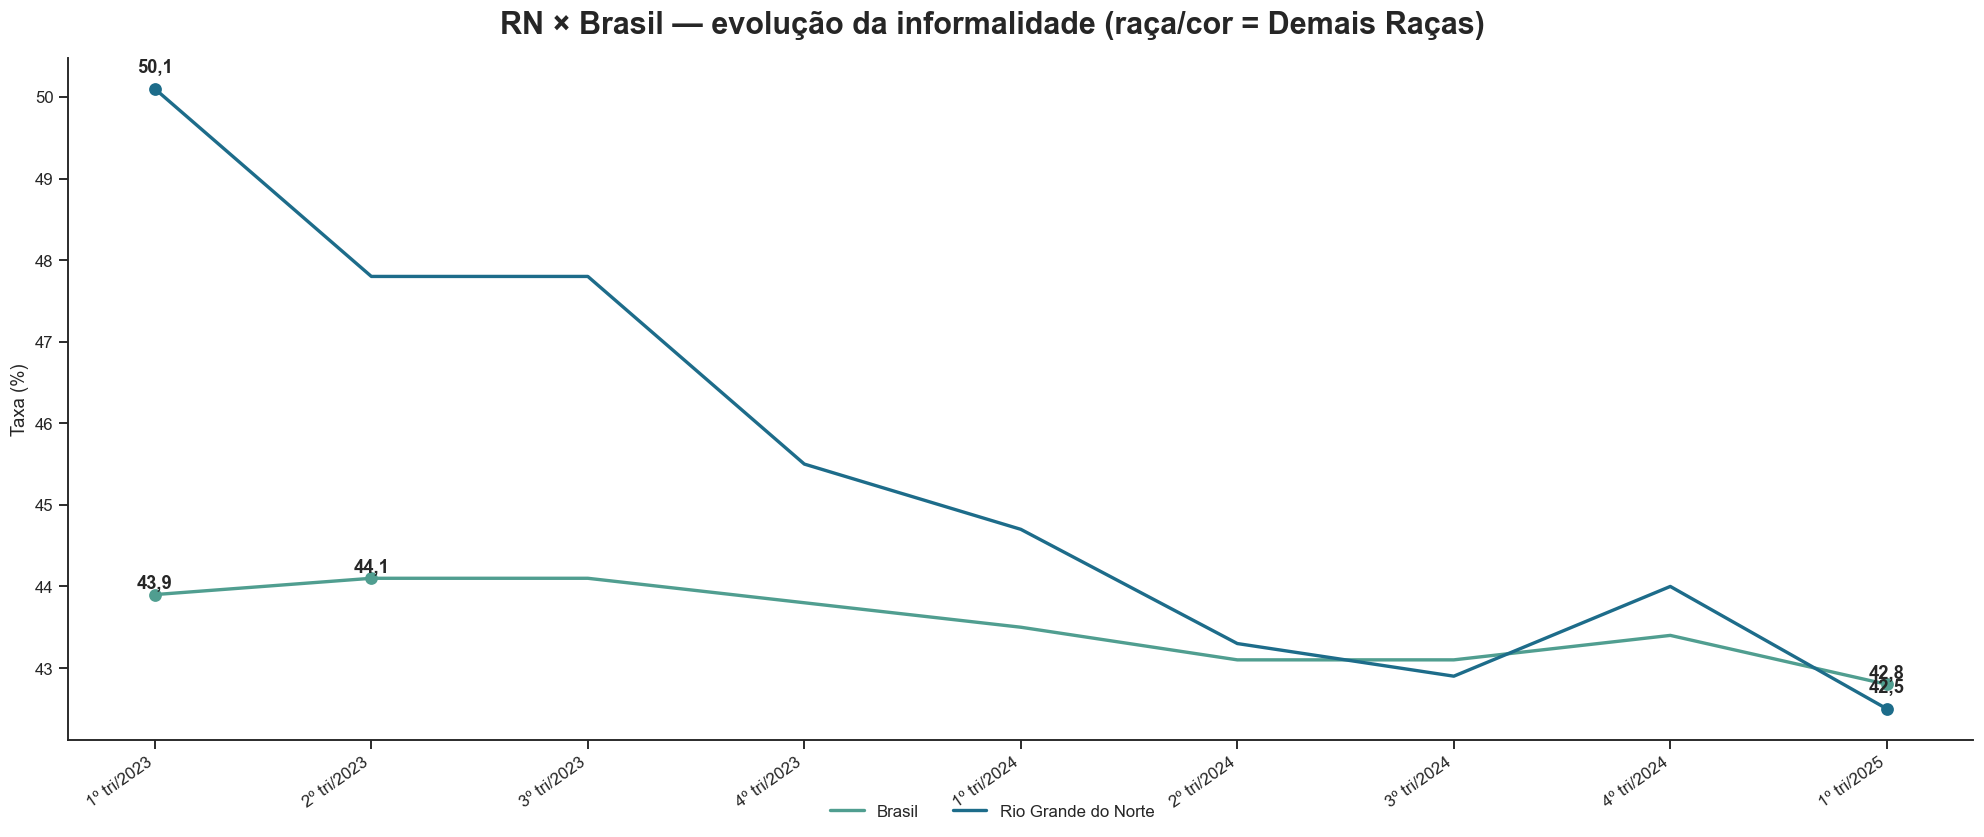

✔ Gráficos salvos em: D:\repositorio_geral\pnad_continua\graficos_python


In [11]:
# ============================================
# Informalidade (Brasil x RN) – G1 a G7
# Visual validado (Arial, sem grade, títulos externos, legendas fora)
# Mostra no VSCode e salva em D:\repositorio_geral\pnad_continua\graficos_python
# ============================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0) Configurações gerais / tema
# -----------------------------
BASE_DIR = r"D:\repositorio_geral\pnad_continua"       # ajuste se necessário
OUT_DIR  = os.path.join(BASE_DIR, "graficos_python")
os.makedirs(OUT_DIR, exist_ok=True)

ARQ_TOTAL = os.path.join(BASE_DIR, "informalidade_total_BR_RN_2023_2025t1.csv")
ARQ_SEXO  = os.path.join(BASE_DIR, "informalidade_por_sexo_BR_RN_2023_2025t1.csv")
ARQ_FAIXA = os.path.join(BASE_DIR, "informalidade_por_faixa_BR_RN_2023_2025t1.csv")
ARQ_RACA  = os.path.join(BASE_DIR, "informalidade_por_raca_BR_RN_2023_2025t1.csv")

# Tenta usar Arial; se não existir, usa DejaVu Sans (evita erro de fonte)
try:
    plt.rcParams["font.family"] = "Arial"
except Exception:
    plt.rcParams["font.family"] = "DejaVu Sans"

# Tema (sem grades, linhas limpas, área de plotagem maior)
plt.rcParams.update({
    "figure.dpi": 110,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "center",
    "axes.titlesize": 18,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "axes.grid": False,                      # SEM grade
    "figure.constrained_layout.use": True,   # títulos/legend fora não colidem
    "axes.titlepad": 10,
    "figure.constrained_layout.h_pad": 0.08,
    "figure.constrained_layout.w_pad": 0.08,
})
sns.set_theme(style="ticks")

# Paletas coerentes (mesma família por gráfico)
PAL_TOTAL = sns.color_palette("crest", 2)      # Brasil x RN
PAL_SEXO  = sns.color_palette("viridis", 2)    # Homem x Mulher
PAL_FAIXA = sns.color_palette("Blues", 9)      # até 9 trimestres
PAL_RACA  = sns.color_palette("Purples", 9)

# Util: formatação PT-BR para valores (43,2)
def fmt_ptbr(v, casas=1):
    if pd.isna(v): return ""
    return f"{v:.{casas}f}".replace(".", ",")

# -----------------------------
# 1) Auxiliares de dados e ordem
# -----------------------------
def ler_csv_pt(path):
    """Lê CSV (write_csv2 do R: sep=';', decimal=',')."""
    return pd.read_csv(path, sep=";", decimal=",")

def ordenar_trimestres(df, col="trimestre"):
    """Ordena rótulos '1º tri/2023' por ano,tri (Categorical)."""
    def parse(s):
        m = re.search(r"(\d+)[ºo]?\s*tri/?\s*(\d{4})", str(s))
        if not m: return (9999, 9)
        tri = int(m.group(1)); ano = int(m.group(2))
        return (ano, tri)
    ordem = sorted(df[col].dropna().unique(), key=parse)
    df[col] = pd.Categorical(df[col], categories=ordem, ordered=True)
    return df

def check_taxa(df, num_col="informais_k", den_col="ocupados_k", taxa_col="taxa_informalidade"):
    """Confere se taxa ≈ (informais/ocupados)*100 (1 casa). Retorna desvio máx absoluto."""
    req = {num_col, den_col, taxa_col}
    if not req.issubset(df.columns): return np.nan
    taxa_calc = (df[num_col] / df[den_col]) * 100
    return float((df[taxa_col] - taxa_calc).abs().max())

# -----------------------------
# 2) Carregar tabelas + ordenar
# -----------------------------
tb_total = ordenar_trimestres(ler_csv_pt(ARQ_TOTAL))
tb_sexo  = ordenar_trimestres(ler_csv_pt(ARQ_SEXO))
tb_faixa = ordenar_trimestres(ler_csv_pt(ARQ_FAIXA))
tb_raca  = ordenar_trimestres(ler_csv_pt(ARQ_RACA))

# Validações mínimas de estrutura
for df, nome, cols in [
    (tb_total, "tb_total", {"trimestre","local","taxa_informalidade"}),
    (tb_sexo,  "tb_sexo",  {"trimestre","local","sexo","taxa_informalidade"}),
    (tb_faixa, "tb_faixa", {"trimestre","local","faixa_etaria","taxa_informalidade"}),
    (tb_raca,  "tb_raca",  {"trimestre","local","raca","taxa_informalidade"}),
]:
    faltam = cols - set(df.columns)
    assert not faltam, f"{nome} sem colunas: {faltam}"

# Sanity check numérico (opcional)
_ = check_taxa(tb_total); _ = check_taxa(tb_sexo); _ = check_taxa(tb_faixa); _ = check_taxa(tb_raca)

# -----------------------------
# 3) Funções de plot reutilizáveis
# -----------------------------
def legend_bottom(fig, labels=None, handles=None, ncol=4, yshift=-0.02):
    """Legenda única no rodapé, sem título, fora dos eixos."""
    if handles is None or labels is None:
        handles, labels = [], []
    fig.legend(handles, labels, loc="lower center", ncol=ncol,
               frameon=False, bbox_to_anchor=(0.5, yshift))

def draw_line_sparse_markers(ax, x, y, label, color, lw=2.2, annotate=True, fsize=12):
    """
    Linha limpa + marcadores apenas em: primeiro, pico (máximo), piso (mínimo) e último.
    """
    ax.plot(range(len(x)), y, color=color, lw=lw, label=label, zorder=2)

    vals = np.asarray(y, dtype=float)
    idx_first = 0
    idx_last  = len(vals)-1
    idx_max   = int(np.nanargmax(vals))
    idx_min   = int(np.nanargmin(vals))
    idxs = list(dict.fromkeys([idx_first, idx_max, idx_min, idx_last]))  # únicos e ordenados

    ymin = np.nanmin(vals); ymax = np.nanmax(vals)
    dy = 0.02 * (ymax - ymin if ymax > ymin else 1.0)

    for i in idxs:
        ax.scatter(i, vals[i], color=color, s=54, zorder=3)
        if annotate:
            ax.text(i, vals[i] + dy, fmt_ptbr(vals[i]), ha="center", va="bottom",
                    fontsize=fsize, fontweight="semibold")

    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(list(x), rotation=35, ha="right")

def polish_axes(ax, ylabel=""):
    """Remove grade, ajusta spines e rótulos menores para evitar conflito."""
    ax.grid(False)
    ax.set_ylabel(ylabel)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def save_show(fig, filename, dpi=400):
    path = os.path.join(OUT_DIR, filename)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# --- NOVO: rótulos esparsos para barras agrupadas (primeiro, máx, mín, último) ---
def annotate_grouped_bars_sparse(ax, df, x, y, hue, x_order, hue_order, fsize=11.5):
    """
    Adiciona rótulos apenas no primeiro, no último, no máximo e no mínimo
    de cada categoria de X (respeitando a ordem de hue).
    """
    # pares (x_val, hue_val) que queremos anotar
    targets = set()
    for xv in x_order:
        serie = (df[df[x] == xv]
                 .set_index(hue)[y]
                 .reindex(hue_order))
        if serie.dropna().empty:
            continue
        targets.add((xv, hue_order[0]))                 # primeiro
        targets.add((xv, hue_order[-1]))                # último
        targets.add((xv, serie.idxmax()))               # máximo
        targets.add((xv, serie.idxmin()))               # mínimo

    # containers: um por nível do hue, na ordem do hue
    for h_idx, cont in enumerate(ax.containers):
        if h_idx >= len(hue_order):      # às vezes inclui contêiner do erro bar
            continue
        h_val = hue_order[h_idx]
        for bar, xv in zip(cont, x_order):
            if (xv, h_val) in targets:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2.0, height,
                        fmt_ptbr(height),
                        ha="center", va="bottom", fontsize=fsize,
                        fontweight="semibold", zorder=5)

# --- NOVO: anotar heatmap esparsamente (primeira/última col., máx e mín por linha) ---
def annotate_heatmap_sparse(ax, pivot_df, fsize=12):
    rows = list(pivot_df.index)
    cols = list(pivot_df.columns)
    for i, r in enumerate(rows):
        row_vals = pivot_df.loc[r, :]
        if row_vals.dropna().empty:
            continue
        j_first, j_last = 0, len(cols) - 1
        j_max = int(row_vals.values.argmax())
        j_min = int(row_vals.values.argmin())
        targets = {j_first, j_last, j_max, j_min}
        for j in targets:
            v = row_vals.iloc[j]
            ax.text(j + 0.5, i + 0.5, fmt_ptbr(v),
                    ha="center", va="center", fontsize=fsize,
                    fontweight="semibold", color="black")

# -----------------------------
# 4) G1 – Série total (Brasil × RN)
# -----------------------------
def plot_G1():
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 8.5), sharex=True)
    fig.suptitle("Informalidade ao longo do tempo — RN em comparação ao Brasil (série trimestral)",
                 fontsize=20, fontweight="bold", y=1.06)

    for i, loc in enumerate(["Brasil", "Rio Grande do Norte"]):
        base = (tb_total.query("local == @loc").sort_values("trimestre"))
        ax = axs[i]
        draw_line_sparse_markers(ax,
                                 x=base["trimestre"],
                                 y=base["taxa_informalidade"],
                                 label=loc, color=PAL_TOTAL[i], fsize=12)
        ax.set_title(loc, fontsize=16, pad=6, fontweight="bold")
        polish_axes(ax, ylabel="Taxa (%)")

    handles = [plt.Line2D([], [], color=PAL_TOTAL[0], lw=2.2),
               plt.Line2D([], [], color=PAL_TOTAL[1], lw=2.2)]
    legend_bottom(fig, ["Brasil", "Rio Grande do Norte"], handles, ncol=2, yshift=-0.02)
    save_show(fig, "G1_informalidade_total_linha.png")

# -----------------------------
# 5) G2 – Série por sexo (Brasil × RN)
# -----------------------------
def plot_G2():
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 9.5), sharex=True)
    fig.suptitle("Quem está mais exposto? Informalidade por sexo (série trimestral)",
                 fontsize=20, fontweight="bold", y=1.06)

    for i, loc in enumerate(["Brasil", "Rio Grande do Norte"]):
        base = (tb_sexo.query("local == @loc").sort_values("trimestre"))
        ax = axs[i]
        for j, sexo in enumerate(["Homem", "Mulher"]):
            df_ = base[base["sexo"] == sexo]
            draw_line_sparse_markers(ax,
                                     x=df_["trimestre"],
                                     y=df_["taxa_informalidade"],
                                     label=sexo, color=PAL_SEXO[j], fsize=12)
        ax.set_title(loc, fontsize=16, pad=6, fontweight="bold")
        polish_axes(ax, ylabel="Taxa (%)")

    handles = [plt.Line2D([], [], color=PAL_SEXO[0], lw=2.2),
               plt.Line2D([], [], color=PAL_SEXO[1], lw=2.2)]
    legend_bottom(fig, ["Homem", "Mulher"], handles, ncol=2, yshift=-0.02)
    save_show(fig, "G2_informalidade_por_sexo_linha.png")

# -----------------------------
# 6) G3 – Barras por faixa etária (cores = trimestre) + rótulos esparsos
# -----------------------------
def plot_G3():
    ord_faixas = ["14 a 24 anos", "25 a 39 anos", "40 a 59 anos", "60 anos ou mais"]
    tb_f = tb_faixa.copy()
    tb_f["faixa_etaria"] = pd.Categorical(tb_f["faixa_etaria"], categories=ord_faixas, ordered=True)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)
    fig.suptitle("Onde a informalidade se concentra? Comparação por faixa etária",
                 fontsize=20, fontweight="bold", y=1.06)

    for i, loc in enumerate(["Brasil", "Rio Grande do Norte"]):
        ax = axs[i]
        base = tb_f.query("local == @loc")
        trimestres = list(base["trimestre"].cat.categories)
        pal = sns.color_palette("Blues", len(trimestres))
        sns.barplot(
            data=base, x="faixa_etaria", y="taxa_informalidade",
            hue="trimestre", palette=pal, ax=ax, dodge=True,
            order=ord_faixas, hue_order=trimestres
        )
        ax.tick_params(axis='x', rotation=12, labelsize=10)
        ax.set_title(loc, fontsize=16, pad=6, fontweight="bold")
        polish_axes(ax, ylabel="Taxa (%)")
        # rótulos esparsos
        annotate_grouped_bars_sparse(ax, base, "faixa_etaria", "taxa_informalidade",
                                     "trimestre", ord_faixas, trimestres, fsize=11.5)
        # legenda fora
        ax.legend(title=None, loc="upper left", bbox_to_anchor=(0, 1.06), ncol=5, frameon=False)

    save_show(fig, "G3_informalidade_por_faixa_barras.png", dpi=350)

# -----------------------------
# 7) G4 – Barras por raça/cor (cores = trimestre) + rótulos esparsos
# -----------------------------
def plot_G4():
    ord_raca = ["Branco", "Preto", "Demais Raças"]
    tb_r = tb_raca.copy()
    tb_r["raca"] = pd.Categorical(tb_r["raca"], categories=ord_raca, ordered=True)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)
    fig.suptitle("Desigualdades na informalidade — recorte por raça/cor",
                 fontsize=20, fontweight="bold", y=1.06)

    for i, loc in enumerate(["Brasil", "Rio Grande do Norte"]):
        ax = axs[i]
        base = tb_r.query("local == @loc")
        trimestres = list(base["trimestre"].cat.categories)
        pal = sns.color_palette("Purples", len(trimestres))
        sns.barplot(
            data=base, x="raca", y="taxa_informalidade",
            hue="trimestre", palette=pal, ax=ax, dodge=True,
            order=ord_raca, hue_order=trimestres
        )
        ax.tick_params(axis='x', rotation=0, labelsize=10)
        ax.set_title(loc, fontsize=16, pad=6, fontweight="bold")
        polish_axes(ax, ylabel="Taxa (%)")
        # rótulos esparsos
        annotate_grouped_bars_sparse(ax, base, "raca", "taxa_informalidade",
                                     "trimestre", ord_raca, trimestres, fsize=11.5)
        ax.legend(title=None, loc="upper left", bbox_to_anchor=(0, 1.06), ncol=5, frameon=False)

    save_show(fig, "G4_informalidade_por_raca_barras.png", dpi=350)

# -----------------------------
# 8) G5 – Gap RN − Brasil (linha)
# -----------------------------
def plot_G5():
    br = tb_total[tb_total["local"] == "Brasil"][["trimestre","taxa_informalidade"]].rename(columns={"taxa_informalidade":"br"})
    rn = tb_total[tb_total["local"] == "Rio Grande do Norte"][["trimestre","taxa_informalidade"]].rename(columns={"taxa_informalidade":"rn"})
    base = (br.merge(rn, on="trimestre", how="inner")
              .sort_values("trimestre")
              .assign(gap=lambda d: d["rn"] - d["br"]))

    fig, ax = plt.subplots(figsize=(18, 7))
    fig.suptitle("Quanto o RN se afasta do Brasil? Gap de informalidade (pontos percentuais)",
                 fontsize=20, fontweight="bold", y=1.08)

    draw_line_sparse_markers(ax,
                             x=base["trimestre"],
                             y=base["gap"],
                             label="Gap RN → Brasil (p.p.)",
                             color=sns.color_palette("crest", 1)[0],
                             fsize=12)
    ax.axhline(0, color="gray", ls="--", lw=1)
    polish_axes(ax, ylabel="p.p.")
    handles = [plt.Line2D([], [], color=sns.color_palette("crest", 1)[0], lw=2.2)]
    legend_bottom(fig, ["Gap RN → Brasil (p.p.)"], handles, ncol=1, yshift=-0.02)
    save_show(fig, "G5_gap_RN_menos_BR.png")

# -----------------------------
# 9) G6 – Heatmap RN (faixa × trimestre) + anotações esparsas
# -----------------------------
def plot_G6():
    rn = tb_faixa[tb_faixa["local"] == "Rio Grande do Norte"].copy()
    pivot = rn.pivot(index="faixa_etaria", columns="trimestre", values="taxa_informalidade")
    fig, ax = plt.subplots(figsize=(20, 9))
    fig.suptitle("RN: onde a informalidade é mais alta? (heatmap por faixa etária e trimestre)",
                 fontsize=20, fontweight="bold", y=1.05)
    sns.heatmap(pivot, cmap="Blues", annot=False, cbar_kws={"label":"Taxa (%)"}, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=18, labelsize=10)
    ax.tick_params(axis='y', labelsize=12)
    # anotações esparsas (primeira, última, máx e mín por linha)
    annotate_heatmap_sparse(ax, pivot, fsize=12)
    save_show(fig, "G6_heatmap_RN_faixa_trimestre.png", dpi=360)

# -----------------------------
# 10) G7 – Séries por raça/cor (3 gráficos separados)
# -----------------------------
def plot_G7():
    ord_raca = ["Branco", "Preto", "Demais Raças"]
    for raca in ord_raca:
        base = tb_raca[tb_raca["raca"] == raca].sort_values("trimestre")
        fig, ax = plt.subplots(figsize=(18, 7))
        fig.suptitle(f"RN × Brasil — evolução da informalidade (raça/cor = {raca})",
                     fontsize=20, fontweight="bold", y=1.05)
        for j, loc in enumerate(["Brasil", "Rio Grande do Norte"]):
            df_ = base[base["local"] == loc]
            draw_line_sparse_markers(ax,
                                     x=df_["trimestre"],
                                     y=df_["taxa_informalidade"],
                                     label=loc,
                                     color=PAL_TOTAL[j], fsize=12)
        polish_axes(ax, ylabel="Taxa (%)")
        handles = [plt.Line2D([], [], color=PAL_TOTAL[0], lw=2.2),
                   plt.Line2D([], [], color=PAL_TOTAL[1], lw=2.2)]
        legend_bottom(fig, ["Brasil", "Rio Grande do Norte"], handles, ncol=2, yshift=-0.02)
        fname = f"G7_raca_{raca.replace(' ', '_')}.png"
        save_show(fig, fname)

# -----------------------------
# Execução
# -----------------------------
if __name__ == "__main__":
    plot_G1()
    plot_G2()
    plot_G3()
    plot_G4()
    plot_G5()
    plot_G6()
    plot_G7()
    print("✔ Gráficos salvos em:", OUT_DIR)
